In [1]:
!pip install optbinning
!pip install flask-ngrok

     |████████████████████████████████| 174kB 6.4MB/s 
     |████████████████████████████████| 14.4MB 189kB/s 
     |████████████████████████████████| 184kB 45.4MB/s 
     |████████████████████████████████| 1.0MB 20.4MB/s 
  Created wheel for pympler: filename=Pympler-0.9-cp37-none-any.whl size=164825 sha256=1209c3eb9097c49489fc4af787af09314a0e9be3e8f6efba31c526d76b0189e3
  Stored in directory: /root/.cache/pip/wheels/23/15/5a/90dd23b3ceffcf8463dc737fba4fad3e295d1da52622bbb74f
  Created wheel for accumulation-tree: filename=accumulation_tree-0.6.2-cp37-cp37m-linux_x86_64.whl size=234375 sha256=7b554c5ad9cca695081da7ca4b71a3ef22791e879dbf243abb1510eef5036b59
  Stored in directory: /root/.cache/pip/wheels/a7/76/fa/3fbcbcf87da8668138b93f9668f56e1029f7d72c7f6a51ab1a
  Created wheel for pyudorandom: filename=pyudorandom-1.0.0-cp37-none-any.whl size=2223 sha256=2d972694f509bdb68cf6641b1d1fb7931612773b6c07a928d6e146181109087b
  Stored in directory: /root/.cache/pip/wheels/18/0e/0c/ec5ba8bed98

## Cargar Datos

In [2]:
### Cargar los paquetes necesarios
import pandas as pd # Paquete para la manipulación de datos
import matplotlib.pyplot as plt #Gráficas estáticas
from sklearn.model_selection import train_test_split # train_test_split es una función que nos permite segmentar nuestro dataframe en test y train
from optbinning import OptimalBinning # Paquete para hacer binning haciendo uso de la transformación WOE 
from sklearn.tree import DecisionTreeClassifier # Cargamos un modelo de árbol
from sklearn.linear_model import LogisticRegressionCV # Cargamos una regresión logística
from sklearn.ensemble import RandomForestClassifier # Cargamos RandomForest
from sklearn.naive_bayes import BernoulliNB # Cargamos Naive Bayes
from sklearn.metrics import classification_report
import warnings

In [4]:
### Cargamos los datos de la página https://archive.ics.uci.edu/ml/datasets/wine+quality
### Los datos estan delimitados por ;, razón por la cual se agraga el parámetro sep con valor de ";"
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep = ";")

In [5]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
### Se cuenta con 1599 Registros y 12 columnas
data.shape

(1599, 12)

## Análisis de valores ausentes
No se tiene ningún valor faltante

In [8]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Análisis Exploratorio

In [9]:

def graficar_variables(df):
    """Función para crear las primeras gráficas de las variables en el dataframe

    Args:
        df ([DataFrame]): DataFrame sobre el cual se aplicará la generación de gráficas
    """
    for col_name, col_values in df.iteritems():
      print(col_values.dtype)
      plt.title(col_name)
      if str(col_values.dtype) == "object":
        temp = col_values.value_counts(normalize = True)
        temp = temp[temp >= 0.05]
        temp.plot.bar()
      else:
        col_values.hist()
      plt.show()


float64


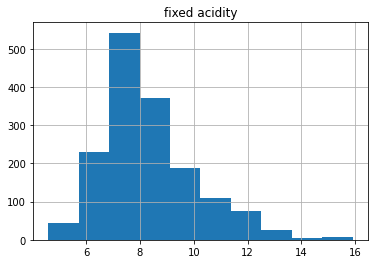

float64


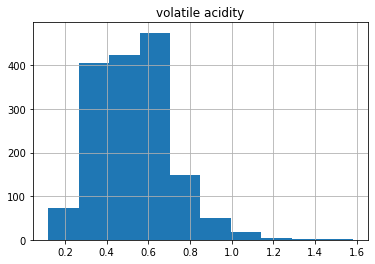

float64


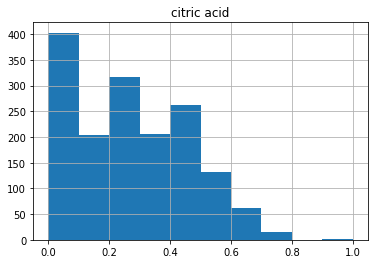

float64


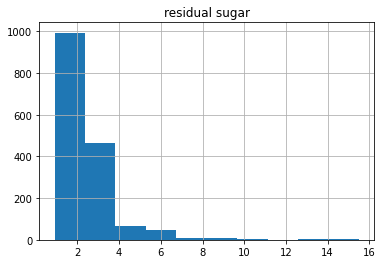

float64


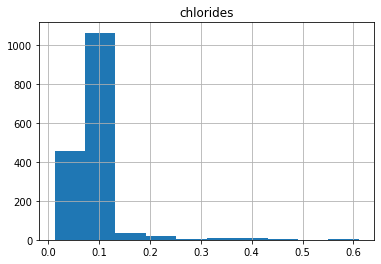

float64


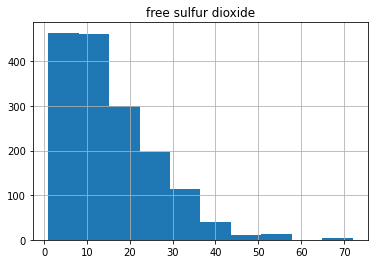

float64


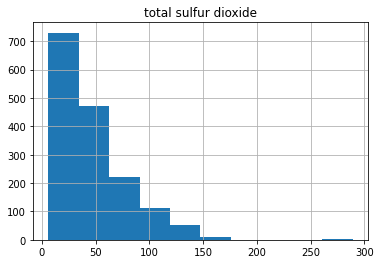

float64


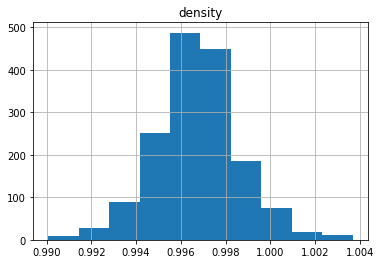

float64


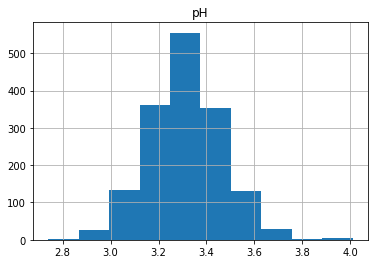

float64


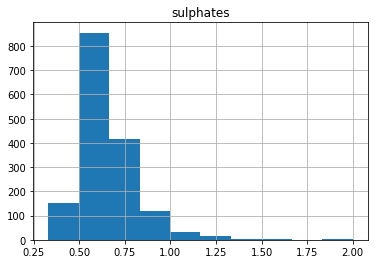

float64


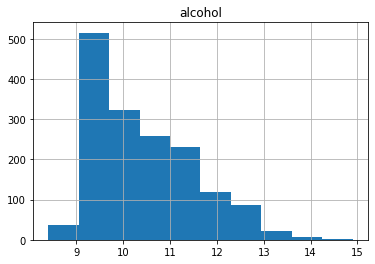

int64


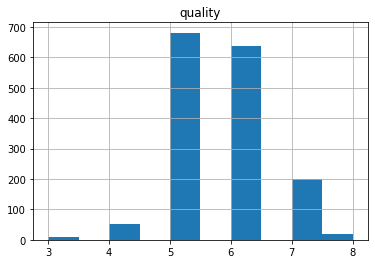

In [10]:
graficar_variables(data)

### Algunas variables tienen un comportamiento con simetría positiva por lo que se obtarán por dos transformaciones importantes en los datos:
* Técnicas de binning en las variables independientes
* Aplicar una trasnformación binaria de los datos, que quede parametrizada

In [11]:

def binario(y, corte_alta = 7):
    """Función convertir la variable cálidad (3,8) a una variable binaria

    Args:
        y ([serie]): calidades registradas
        corte_alta ([int]): número con el que se toma el corte para considerar un vino de calidad "buena"
    """
    return y > corte_alta


## Segmentación de DataFrame

In [12]:
X = data.iloc[:,:-1]
y = binario(data.iloc[:,-1], 5)
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=.20, random_state = 100, stratify = y)

In [13]:
print(X)

      fixed acidity  volatile acidity  citric acid  ...    pH  sulphates  alcohol
0               7.4             0.700         0.00  ...  3.51       0.56      9.4
1               7.8             0.880         0.00  ...  3.20       0.68      9.8
2               7.8             0.760         0.04  ...  3.26       0.65      9.8
3              11.2             0.280         0.56  ...  3.16       0.58      9.8
4               7.4             0.700         0.00  ...  3.51       0.56      9.4
...             ...               ...          ...  ...   ...        ...      ...
1594            6.2             0.600         0.08  ...  3.45       0.58     10.5
1595            5.9             0.550         0.10  ...  3.52       0.76     11.2
1596            6.3             0.510         0.13  ...  3.42       0.75     11.0
1597            5.9             0.645         0.12  ...  3.57       0.71     10.2
1598            6.0             0.310         0.47  ...  3.39       0.66     11.0

[1599 rows x 11

In [14]:
print(y)

0       False
1       False
2       False
3        True
4       False
        ...  
1594    False
1595     True
1596     True
1597    False
1598     True
Name: quality, Length: 1599, dtype: bool


## Transformación de variables

In [16]:
op_bin = {}
X_train_WOE = pd.DataFrame({})
for variable in X_train.columns:
    optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
    optb.fit(X_train[variable], y_train)
    if optb.status == "OPTIMAL":
        X_train_WOE[variable] = optb.transform(X_train[variable])
        op_bin.update({
            variable:
            {"optb":optb, "table":optb.binning_table.build()}
        })
        op_bin[variable]["importance"] = op_bin[variable]["table"].IV.sum()
    else:
        pass

In [17]:
optb.transform(
    X_train[variable])

array([-2.16318858,  0.67619762, -0.7245684 , ..., -0.7245684 ,
       -0.08766094, -2.01526845])

In [ ]:
X_train_WOE

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.197076,0.563730,0.396116,0.349692,-0.898255,-0.566823,-0.274642,-1.401049,0.200021,0.633415,-2.163189
1,0.085971,-0.188820,0.396116,-0.023122,0.205917,0.151667,-0.274642,0.343309,0.002598,0.443392,0.676198
2,0.213504,-1.548685,-0.276764,0.004477,-0.898255,0.022425,-0.274642,-0.984534,0.002598,1.931156,-0.724568
3,0.206838,-0.188820,-0.276764,-0.085185,-0.086043,-0.026047,-0.162390,0.427079,-0.051178,1.931156,1.397073
4,0.085971,0.764076,0.396116,-0.085185,0.152300,-0.566823,-0.274642,0.021613,0.002598,0.443392,0.248030
...,...,...,...,...,...,...,...,...,...,...,...
1274,0.418981,-0.445537,-0.276764,0.004477,0.205917,0.022425,0.290946,0.343309,-0.051178,-0.293468,0.993812
1275,-0.705667,-0.824041,-0.477913,0.266148,-0.086043,-0.026047,-0.274642,-0.062630,-0.416129,-0.954575,-0.724568
1276,0.085971,-0.188820,0.396116,-0.387624,0.205917,0.022425,-0.162390,0.427079,-0.051178,-0.954575,-0.724568
1277,0.418981,-0.824041,-0.477913,-0.085185,0.152300,0.151667,-0.514530,0.200954,-0.416129,0.633415,-0.087661


In [ ]:
X_test_WOE = pd.DataFrame({})
for variable, valores in op_bin.items():    
    X_test_WOE[variable] = valores["optb"].transform(X_test[variable])
X_test_WOE

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.418981,-0.188820,-0.477913,-0.085185,0.581229,-0.057314,-0.274642,0.343309,-0.416129,-0.187816,-0.087661
1,0.078028,1.222741,0.063685,0.004477,0.205917,0.151667,-0.274642,-1.401049,0.200021,1.931156,-2.163189
2,0.420299,0.154434,0.396116,0.004477,0.152300,-0.026047,-0.274642,0.805875,-0.051178,-0.954575,0.993812
3,0.214904,0.563730,0.063685,-0.085185,0.205917,0.151667,-0.274642,-0.062630,0.200021,-0.954575,0.993812
4,0.213504,0.764076,0.063685,-0.085185,-0.898255,0.022425,-0.274642,-0.984534,-0.051178,0.443392,-2.015268
...,...,...,...,...,...,...,...,...,...,...,...
315,-0.197076,0.563730,-0.276764,0.004477,0.205917,-0.026047,0.290946,0.343309,-0.051178,-0.954575,1.397073
316,-0.705667,-0.824041,-0.635429,-0.023122,0.205917,-0.026047,-0.162390,-0.062630,0.120165,-0.093697,-0.724568
317,0.214904,-0.824041,0.396116,-0.387624,0.745532,0.022425,-0.162390,0.343309,-0.051178,-0.293468,-0.724568
318,0.085971,-0.824041,-0.276764,-0.387624,0.152300,-0.026047,-0.162390,0.200954,0.002598,-0.954575,-0.724568


## Importancia de variables

### Usando el Information Value

In [ ]:
importance_WOE = pd.DataFrame([(variable, valores["importance"]) for variable, valores in op_bin.items()], columns = ["variable", "importancia"]).sort_values("importancia", ascending = False)

### Usando Desicion Tree


In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
importance_tree = pd.DataFrame(zip(X_train.columns, tree.feature_importances_), columns = ["variable", "importancia"]).sort_values("importancia", ascending = False)
importance_tree

,variable,importancia
10,alcohol,0.228748
9,sulphates,0.150470
4,chlorides,0.101810
6,total sulfur dioxide,0.094361
1,volatile acidity,0.068713
0,fixed acidity,0.068107
3,residual sugar,0.067016
8,pH,0.062085
2,citric acid,0.062074
7,density,0.061266


### Usando RandomForest


In [ ]:
tree = RandomForestClassifier()
tree.fit(X_train, y_train)
importance_randomforest = pd.DataFrame(zip(X_train.columns, tree.feature_importances_), columns = ["variable", "importancia"]).sort_values("importancia", ascending = False)
importance_randomforest

,variable,importancia
10,alcohol,0.174653
9,sulphates,0.141976
6,total sulfur dioxide,0.103365
1,volatile acidity,0.095538
7,density,0.093427
4,chlorides,0.074499
0,fixed acidity,0.070642
8,pH,0.069698
2,citric acid,0.062511
5,free sulfur dioxide,0.057830


### Resultado

In [ ]:
tabla_importancia = importance_WOE.merge(importance_tree, on = "variable", suffixes=["_WOE", "_tree"]).merge(importance_randomforest, on = "variable", suffixes=["", "_randomtree"])

In [ ]:
### Para poder compara se normaliza la escala de las importancias
tabla_importancia.apply(lambda x: (x - min(x))/(max(x) - min(x)) if not isinstance(x.values[0], str) else x, axis = 0)

,variable,importancia_WOE,importancia_tree,importancia
0,alcohol,1.000000,1.000000,1.000000
1,sulphates,0.584538,0.595249,0.724920
2,volatile acidity,0.474494,0.172514,0.334005
3,total sulfur dioxide,0.321359,0.305132,0.399896
4,density,0.305916,0.134008,0.316233
5,chlorides,0.181693,0.343646,0.156895
6,citric acid,0.160173,0.138186,0.055985
7,fixed acidity,0.090949,0.169381,0.124428
8,free sulfur dioxide,0.031760,0.000000,0.016578
9,residual sugar,0.014185,0.163740,0.000000


## Modelo

In [ ]:
class Modelo():
    def __init__(self):
        self.modelos = [
            DecisionTreeClassifier(),
            LogisticRegressionCV(),
            RandomForestClassifier(),
            BernoulliNB()
        ]
    def fit(self, X, y):
        for modelo in self.modelos:
            modelo.fit(X, y)
        # self.modelos = [
        #     DecisionTreeClassifier.fit(X = X, y = y),
        #     LogisticRegressionCV.fit(X = X, y = y),
        #     RandomForestClassifier.fit(X = X, y = y),
        #     BernoulliNB.fit(X = X, y = y)
        # ]
    def predict_report(self, X,y):
        for modelo in self.modelos:
            print(modelo)
            y_hat = modelo.predict(X)
            print(classification_report(y, y_hat))
            print("=====================================\n\n\n")
            

In [ ]:
modelo = Modelo()

In [ ]:
warnings.filterwarnings('ignore')
modelo.fit(X_train, y_train)
warnings.filterwarnings('always')


In [ ]:
modelo.predict_report(X_test, y_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
              precision    recall  f1-score   support

       False       0.72      0.72      0.72       149
        True       0.76      0.76      0.76       171

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320




LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalt

In [ ]:
modelo = Modelo()
warnings.filterwarnings('ignore')
modelo.fit(X_train_WOE, y_train)
warnings.filterwarnings('always')
modelo.predict_report(X_test_WOE, y_test)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
              precision    recall  f1-score   support

       False       0.73      0.74      0.74       149
        True       0.77      0.77      0.77       171

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320




LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalt

In [ ]:
X_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [ ]:
# flask_ngrok_example.py
from flask import Flask
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route("/")
def hello():
    return "Hello World!"

if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://3ef4339747dd.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [19/Jun/2021 06:32:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2021 06:32:00] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
from flask import render_template_string;
from flask import render_template
app = Flask(__name__)
run_with_ngrok(app) 

template = """
{%for cel in result%}
<div class="cel-item">
<ul>
  <li>{{cel["NAME"]}}</li>
  <li>{{cel["PRICE"]}}</li>
  <li>{{cel["Memoria Interna"]}}</li>
  <li>{{cel["Phone Memory (RAM)"]}}</li>
  <li>{{cel["Compañía telefónica"]}}</li>
  <li>{{cel["Cámara trasera"]}}</li>
  <li>{{cel["Cámara frontal"]}}</li>
</ul>
</div>
{%endfor%}
"""

template_none = """

"""
@app.route('/advisor1', methods=['GET'])
def login():
  mem = request.args.get('minmem',None)
  mem = int(mem) if mem != None else None
  ram = request.args.get('minram',None)
  ram = int(ram) if ram != None else None
  cam = request.args.get('mincam',None)
  cam = int(cam) if cam != None else None
  color = request.args.get('color',None)
  price = request.args.get('price',None) #Bajo Alto Medio
  print(color)
  n = request.args.get('n',10)

  res = [frame.iloc[v] for v in plain_search(Color=color,PriceRange=price,MinMem=mem,MinRam=ram,MinCam=cam,n=n)]
  if len(res) == 0:
    return render_template_string(template,result=res);
      
  return render_template_string(template,result=res);

@app.route('/')
def index():
    return render_template('index.html')

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://4027655dfb7c.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [19/Jun/2021 06:49:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2021 06:49:58] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:49:58] "GET /socket.io/?EIO=3&transport=polling&t=NeZ285- HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:49:59] "GET /socket.io/?EIO=3&transport=polling&t=NeZ28SY HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:50:01] "GET /socket.io/?EIO=3&transport=polling&t=NeZ28zi HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:50:05] "GET /socket.io/?EIO=3&transport=polling&t=NeZ29zb HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:50:11] "GET /socket.io/?EIO=3&transport=polling&t=NeZ2BSX HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:50:17] "GET /socket.io/?EIO=3&transport=polling&t=NeZ2CwH HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:50:23] "GET /socket.io/?EIO=3&transport=polling&t=NeZ2EO2 HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:50:29] "GET /socket.io/?EIO=3&transport=polling&t=NeZ2Frn HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2021 06:50:35] 

In [ ]:
!mkdir templates

In [ ]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
  <title>Bootstrap Example</title>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.1/css/bootstrap.min.css">
  <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js"></script>
  <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.1/js/bootstrap.min.js"></script>
</head>
<body>

<div class="container">
  <h2>Sistema Experto</h2>
  <form method="GET" action="/advisor1">
    <div class="form-group">
      <label for="minmem">Memoria interna mínima</label>
      <select class="form-control form-control-lg"  id= "minmem" name= "minmem">
        <option value = "16">16</option>
        <option value = "32">32</option>
        <option value = "48">48</option>
        <option value = "64">64</option>
        <option value = "128">128</option>
        <option value = "256">256</option>
        <option value = "512">512</option>
      </select>
      <label for="minram">Memoria RAM mínima</label>
      <select class="form-control form-control-lg"  id= "minram" name= "minram">
        <option value = "1">1</option>
        <option value = "2">2</option>
        <option value = "3">3</option>
        <option value = "4">4</option>
        <option value = "6">6</option>
        <option value = "8">8</option>
        <option value = "12">12</option>
      </select>
      <label for="mincam">Megapíxeles mínimos</label>
      <select class="form-control form-control-lg"  id= "mincam" name= "mincam">
        <option value = "12">12</option>
        <option value = "13">13</option>
        <option value = "16">16</option>
        <option value = "19">19</option>
        <option value = "20">20</option>
        <option value = "24">24</option>
        <option value = "32">32</option>
        <option value = "40">40</option>
        <option value = "48">48</option>
      </select>
      <label for="color">Color</label>
      <select class="form-control form-control-lg"  id= "color" name= "color">
        <option value = 'Rosa' >Rosa </option>
        <option value = 'Plata' >Plata </option>
        <option value = 'Negro' >Negro </option>
        <option value = 'Multi'>Multi</option>
        <option value = 'Verde Medianoche' >VerdeMedianoche </option>
        <option value = 'Dorado'>Dorado</option>
        <option value = 'Rojo'>Rojo</option>
        <option value = 'Verde'>Verde</option>
        <option value = 'Azul'>Azul</option>
        <option value = 'MOrado'>MOrado</option>
        <option value = 'Blanco'>Blanco</option>
        <option value = 'Mora Azul'>Mora Azul</option>
        <option value = 'Red'>Red</option>
        <option value = 'Lavanda'>Lavanda</option>
        <option value = 'Gris Espacial'>Gris Espacial</option>
        <option value = 'Oro' >'Oro' </option>
        <option value = 'Azul Aurora' >Azul Aurora </option>
        <option value = 'Blanco Polar' >Blanco Polar </option>
        <option value = 'Gris Medianoche'>Gris Medianoche</option>
        <option value = 'Gris' >'Gris' </option>
        <option value = 'Space Gray' >Space Gray </option>
        <option value = 'Oro Rosa' >Oro Rosa </option>
        <option value = 'Espejo Negro' >Espejo Negro </option>
        <option value = 'Espejo Púrpura'>Espejo Púrpura</option>
        <option value = 'Negro Medianoche' >Negro Medianoche </option>
        <option value = 'Lila'>Lila</option>
        <option value = 'Bronce' >Bronce </option>
        <option value = 'Morado' >Morado </option>
        <option value = 'Frambuesa'>Frambuesa</option>
        <option value = 'Azul Claro'>Azul Claro</option>
        <option value = 'Moka'>Moka</option> 
      </select>
      <label for="price">Precio</label>
      <select class="form-control form-control-lg"  id= "price" name= "price">
        <option value = "Alto">Alto</option>
        <option value = "Bajo">Medio</option>
        <option value = "Medio">Bajo</option>
      </select>
    </div>
    <button type="submit" class="btn btn-default" >Submit</button>
  </form>
</div>

</body>
</html>


Writing templates/index.html


In [ ]:
%%writefile templates/index.html
<!doctype html>
<html lang="en">

<head>
  <meta charset="utf-8">
  <meta http-equiv="X-UA-Compatible" content="IE=edge">
  <meta name="description" content="Learn how to create a chat app using Flask">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Flask Chat</title>

  <!-- Disable tap highlight on IE -->
  <meta name="msapplication-tap-highlight" content="no">

  <!-- Web Application Manifest -->
  <link rel="manifest" href='data:application/manifest+json,{ "name": "Flask Chat", "short_name": "Flask Chat", "display": "standalone" }' />
  
  <!-- Add to homescreen for Chrome on Android -->
  <meta name="mobile-web-app-capable" content="yes">
  <meta name="application-name" content="Flask Chat">
  <meta name="theme-color" content="#303F9F">

  <!-- Add to homescreen for Safari on iOS -->
  <meta name="apple-mobile-web-app-capable" content="yes">
  <meta name="apple-mobile-web-app-status-bar-style" content="black-translucent">
  <meta name="apple-mobile-web-app-title" content="Flask Chat">
  <meta name="apple-mobile-web-app-status-bar-style" content="#303F9F">

  <!-- Tile icon for Win8 -->
  <meta name="msapplication-TileColor" content="#3372DF">
  <meta name="msapplication-navbutton-color" content="#303F9F">
  <script async src="https://www.googletagmanager.com/gtag/js?id=UA-135532366-1"></script>
  <script>function gtag(){dataLayer.push(arguments)}window.dataLayer=window.dataLayer||[],gtag("js",new Date),gtag("config","UA-135532366-1");</script>

  <!-- Material Design Lite -->
  <link rel="stylesheet" href="https://fonts.googleapis.com/icon?family=Material+Icons">
  <link rel="stylesheet" href="https://code.getmdl.io/1.1.3/material.orange-indigo.min.css">
  <script defer src="https://code.getmdl.io/1.1.3/material.min.js"></script>

  <!-- App Styling -->
  <link rel="stylesheet"
    href="https://fonts.googleapis.com/css?family=Roboto:regular,bold,italic,thin,light,bolditalic,black,medium&amp;lang=en">
  <style>
    .message-container .spacing {
      display: table-cell;
      vertical-align: top;
    }

    .message-container .message {
      display: table-cell;
      width: calc(100% - 40px);
      padding: 5px 0 5px 10px;
    }

    .message-container .name {
      display: inline-block;
      width: 100%;
      padding-left: 40px;
      color: #bbb;
      font-style: italic;
      font-size: 12px;
      box-sizing: border-box;
    }
  </style>
</head>

<body>
  <div class="demo-layout mdl-layout mdl-js-layout mdl-layout--fixed-header">

    <!-- Header section containing logo -->
    <header class="mdl-layout__header mdl-color-text--white mdl-color--light-blue-700">
      <div class="mdl-cell mdl-cell--12-col mdl-cell--12-col-tablet mdl-grid">
        <div class="mdl-layout__header-row mdl-cell mdl-cell--12-col mdl-cell--12-col-tablet mdl-cell--12-col-desktop">
          <h3><i class="material-icons">mobile_screen_share</i> Mobile Advisor</h3>
        </div>
      </div>
    </header>

    <main class="mdl-layout__content mdl-color--grey-100">
      <div id="messages-card-container" class="mdl-cell mdl-cell--12-col mdl-grid">

        <!-- Messages container -->
        <div id="messages-card"
          class="mdl-card mdl-shadow--2dp mdl-cell mdl-cell--12-col mdl-cell--6-col-tablet mdl-cell--6-col-desktop">
          <div class="mdl-card__supporting-text mdl-color-text--grey-600">
            <div id="messages">
              <span id="message-filler"></span>
              <div class="message-container visible">
                <div class="spacing">
                </div>
                <div class="message">Welcome!</div>
                <div class="name">Shanaka DeSoysa</div>
              </div>
            </div>
<h2>Sistema Experto</h2>
  <form method="GET" action="/advisor1">
    <div class="form-group">
      <label for="minmem">Memoria interna mínima</label>
      <select class="form-control form-control-lg"  id= "minmem" name= "minmem">
        <option value = "16">16</option>
        <option value = "32">32</option>
        <option value = "48">48</option>
        <option value = "64">64</option>
        <option value = "128">128</option>
        <option value = "256">256</option>
        <option value = "512">512</option>
      </select>
      <label for="minram">Memoria RAM mínima</label>
      <select class="form-control form-control-lg"  id= "minram" name= "minram">
        <option value = "1">1</option>
        <option value = "2">2</option>
        <option value = "3">3</option>
        <option value = "4">4</option>
        <option value = "6">6</option>
        <option value = "8">8</option>
        <option value = "12">12</option>
      </select>
      <label for="mincam">Megapíxeles mínimos</label>
      <select class="form-control form-control-lg"  id= "mincam" name= "mincam">
        <option value = "12">12</option>
        <option value = "13">13</option>
        <option value = "16">16</option>
        <option value = "19">19</option>
        <option value = "20">20</option>
        <option value = "24">24</option>
        <option value = "32">32</option>
        <option value = "40">40</option>
        <option value = "48">48</option>
      </select>
      <label for="color">Color</label>
      <select class="form-control form-control-lg"  id= "color" name= "color">
        <option value = 'Rosa' >Rosa </option>
        <option value = 'Plata' >Plata </option>
        <option value = 'Negro' >Negro </option>
        <option value = 'Multi'>Multi</option>
        <option value = 'Verde Medianoche' >VerdeMedianoche </option>
        <option value = 'Dorado'>Dorado</option>
        <option value = 'Rojo'>Rojo</option>
        <option value = 'Verde'>Verde</option>
        <option value = 'Azul'>Azul</option>
        <option value = 'MOrado'>MOrado</option>
        <option value = 'Blanco'>Blanco</option>
        <option value = 'Mora Azul'>Mora Azul</option>
        <option value = 'Red'>Red</option>
        <option value = 'Lavanda'>Lavanda</option>
        <option value = 'Gris Espacial'>Gris Espacial</option>
        <option value = 'Oro' >'Oro' </option>
        <option value = 'Azul Aurora' >Azul Aurora </option>
        <option value = 'Blanco Polar' >Blanco Polar </option>
        <option value = 'Gris Medianoche'>Gris Medianoche</option>
        <option value = 'Gris' >'Gris' </option>
        <option value = 'Space Gray' >Space Gray </option>
        <option value = 'Oro Rosa' >Oro Rosa </option>
        <option value = 'Espejo Negro' >Espejo Negro </option>
        <option value = 'Espejo Púrpura'>Espejo Púrpura</option>
        <option value = 'Negro Medianoche' >Negro Medianoche </option>
        <option value = 'Lila'>Lila</option>
        <option value = 'Bronce' >Bronce </option>
        <option value = 'Morado' >Morado </option>
        <option value = 'Frambuesa'>Frambuesa</option>
        <option value = 'Azul Claro'>Azul Claro</option>
        <option value = 'Moka'>Moka</option> 
      </select>
      <label for="price">Precio</label>
      <select class="form-control form-control-lg"  id= "price" name= "price">
        <option value = "Alto">Alto</option>
        <option value = "Bajo">Medio</option>
        <option value = "Medio">Bajo</option>
      </select>
    </div>
    <button type="submit" class="btn btn-default" >Submit</button>
  </form>
          </div>
        </div>
      </div>
    </main>
  </div>
  <!-- jQuery (necessary for Bootstrap's JavaScript plugins) -->
  <script src="https://ajax.googleapis.com/ajax/libs/jquery/1.12.4/jquery.min.js"></script>
  <script src="https://cdnjs.cloudflare.com/ajax/libs/socket.io/1.7.3/socket.io.min.js"></script>
  <script type="text/javascript">
    var socket = io.connect('https://' + document.domain + ':' + location.port);

    socket.on('connect', function () {
      socket.emit('flask-chat-event', {
        data: 'User Connected'
      })
      var form = $('form').on('submit', function (e) {
        e.preventDefault()
        let user_name = $('#username').val()
        let user_input = $('#message').val()
        socket.emit('flask-chat-event', {
          user_name: user_name,
          message: user_input
        })
        $('#message').val('').focus()
      })
    })
    socket.on('flask-chat-response', function (msg) {
      console.log(msg)
      if (typeof msg.user_name !== 'undefined') {
        $('#messages').append('<div class="message-container visible"><div class="spacing"></div><div class="message">' + msg.message + '</div><div class="name">' + msg.user_name + '</div></div>')
      }
    })
  </script>
</body>

</html>

Overwriting templates/index.html
